# Assignment 2 Part 1: Volume Rendering

In assignment 1, we rendered the implicit surface of a volume using ray marching. In this part of the assignment, we will extend our ray marcher to perform volume rendering using emission-absorption models.

In [1]:
import slangpy as spy
from pyglm import glm
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

from cs248a_renderer import setup_device, RendererModules
from cs248a_renderer.model.mesh import Mesh
from cs248a_renderer.model.material import PhysicsBasedMaterial, MaterialField, FilteringMethod
from cs248a_renderer.model.scene import Scene
from cs248a_renderer.renderer.core_renderer import Renderer
from cs248a_renderer.model.volumes import DenseVolume
from cs248a_renderer.model.transforms import Transform3D

objc[59357]: Class GLFWHelper is implemented in both /Users/tejank10/cs248a-renderer-internal/.venv/lib/python3.12/site-packages/slangpy/libsgl.dylib (0x109a6d248) and /Users/tejank10/cs248a-renderer-internal/.venv/lib/python3.12/site-packages/open3d/cpu/pybind.cpython-312-darwin.so (0x11b80fa28). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[59357]: Class GLFWApplicationDelegate is implemented in both /Users/tejank10/cs248a-renderer-internal/.venv/lib/python3.12/site-packages/slangpy/libsgl.dylib (0x109a6d298) and /Users/tejank10/cs248a-renderer-internal/.venv/lib/python3.12/site-packages/open3d/cpu/pybind.cpython-312-darwin.so (0x11b80fa78). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[59357]: Class GLFWWindowDelegate is implemented in both /Users/tejank10/cs248a-renderer-internal/.venv/lib/python3.12/site-packages/slangpy/libsgl.dylib (

In [2]:
# Device setup
device = setup_device([])
renderer_modules = RendererModules(device)

[INFO] (rhi) layer: CreateDevice: Debug layer is enabled.
[WARN] No supported shader model found, pretending to support sm_6_0.


In [3]:
# We setup the output image similar to part 1
OUTPUT_IMG_SIZE = (512, 512)
output_image = device.create_texture(
    type=spy.TextureType.texture_2d,
    format=spy.Format.rgba32_float,
    usage=spy.TextureUsage.unordered_access,
    width=OUTPUT_IMG_SIZE[0],
    height=OUTPUT_IMG_SIZE[1],
)

In [4]:
renderer = Renderer(
    device=device,
    render_texture=output_image,
    render_modules=renderer_modules
)
renderer.sqrt_spp = 1

## Radiance Absorption Model

Let's first implement the radiance absorption model of the volume. In this model, the volume absorbs light as the ray travels through it, resulting in a decrease in radiance.

Let's first load in the volume we're rendering. Download the `bunny_cloud.npy` and `background.obj` file from the  assignment 2 resources folder: https://drive.google.com/drive/folders/1biYrBrNYx1sBlkcuyx3RARH9g9PaVHgL?usp=share_link and save it in the `resources` directory.

The volume data here is a 3D numpy array representing the density values of the volume at each voxel. We'll extend it to have 4 channels (RGBA) for volume emission later. But right now, we only need the alpha channel for absorption.

In [5]:
# Load volume data
volume_data = np.load("../../resources/bunny_cloud.npy")
# Extend the volume_data to have 4 channels (RGBA)
volume_data_rgba = np.zeros(volume_data.shape + (4,), dtype=np.float32)
volume_data_rgba[..., 3] = volume_data  # Set alpha channel
volume_data_rgba[..., 0:3] = 0.0  # Set RGB channels to black (full absorption)
volume_data_rgba.shape

(145, 144, 110, 4)

Now, we'll load this volume to the renderer and use ray maching to render it. Your `renderer.slang` will get access to this volume data through the `volume` field in `RendererUniform`. Unlike the `Volume` struct we used in assignment 1 for implicit surface rendering, this new `DiffVolume` is using a `DiffTexture3D` to store the volume data. As implied by the name, we'll later make this texture differentiable and recover volume data through optimization!

In `src/cs248a_renderer/slang_shaders/texture/diff_texture.slang`, we provided the `sampleTrilinear` function to sample from `DiffTexture3D`. You should be familiar with this after completing assignment 1.

Your task is to:

1. Implement `accumulateColor` in `src/cs248a_renderer/slang_shaders/renderer/volume_renderer.slang` to calculate the color of a ray traveling through the volume with absorption only.
2. Implement `volumeSample` in the same file to perform ray marching through the volume and accumulate color using `accumulateColor`.

Note that we're performing the ray-primitive intersection pretending that there's no volume in the scene before ray marching. This means that if the ray hits a primitive before entering the volume, we should use the color of that primitive as the background color for volume rendering.

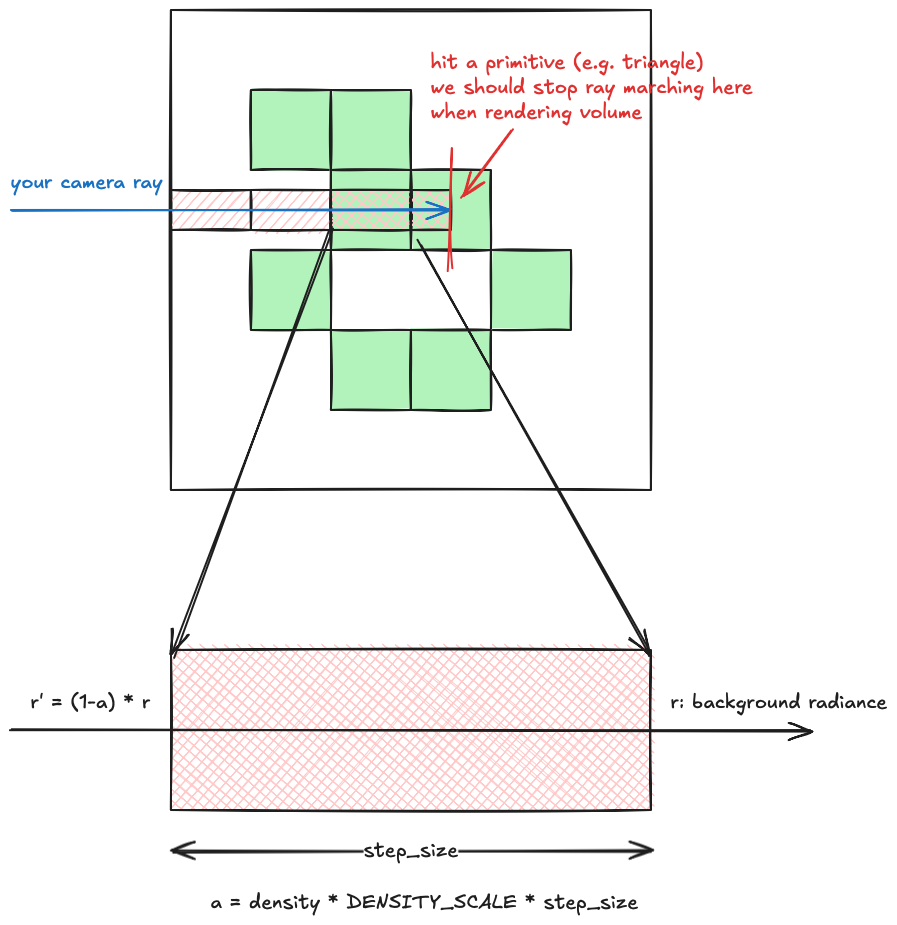

Once you have implemented the above functions correctly, you should be able to see the following rendered result:

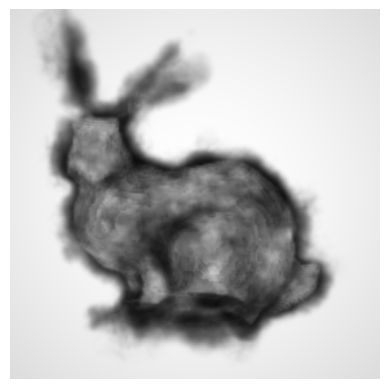

In this image, the more volume density the ray travels through, the darker the color becomes due to absorption.

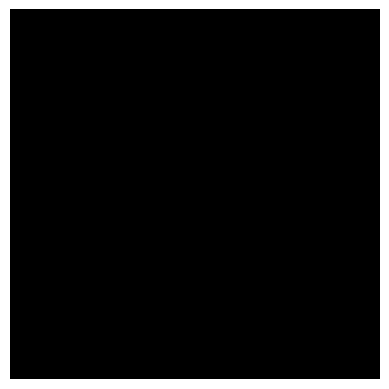

In [6]:
import open3d as o3d

scene = Scene()
cam = scene.camera
cam_pos = glm.vec3(0.0, 0.0, 4.0)
cam.transform.position = cam_pos
cam.transform.rotation = glm.quatLookAt(glm.normalize(-cam_pos), glm.vec3(0.0, 1.0, 0.0))

# We'll load a background mesh to better visualize the volume attenuation
o3d_mesh = o3d.io.read_triangle_mesh("../../resources/background.obj")
mesh = Mesh(o3d_mesh)
mesh.transform = Transform3D(
    position=glm.vec3(0.0, 0.0, -2.0),
    rotation=glm.angleAxis(glm.radians(90.0), glm.vec3(1.0, 0.0, 0.0)),
    scale=glm.vec3(1.0, 1.0, 1.0) * 2.5
)
mesh.material = PhysicsBasedMaterial(
    albedo=MaterialField(
        uniform_value=glm.vec3(1.0, 1.0, 1.0),
    )
)
scene.add_object(mesh)

# Now, let's create the volume object.
volume = DenseVolume(
    name="volume",
    transform=Transform3D(
        position=glm.vec3(0.0, 0.0, 0.0),
        rotation=glm.angleAxis(glm.radians(90.0), glm.vec3(0.0, 1.0, 0.0)),
        scale=glm.vec3(1.0, 1.0, 1.0),
    ),
    data=volume_data_rgba.astype(np.float32),
    properties={
        "pivot": (0.5, 0.5, 0.5),
        "voxel_size": 0.02, # The size of each voxel in world units
    }
)

# Render the volume with absorption
renderer.load_triangles(scene=scene)
renderer.load_volume(volume=volume)
renderer.sqrt_spp = 1
renderer.render(
    scene.camera.view_matrix(),
    scene.camera.fov
)
plt.imshow(np.flipud(output_image.to_numpy()))
plt.axis('off')
plt.show()

## Volume with Emission and Absorption

Now, let's etend our volume rendering to include both emission and absorption. In this model, the volume not only absorbs light but also emits light as the ray travels through it. So for each step along the ray, we need to both attenuate the incoming radiance and add the emitted radiance from the volume:

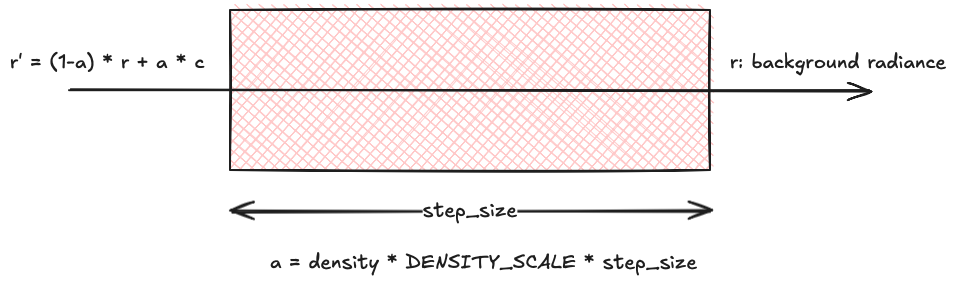

You should update your `accumulateColor` function in `src/cs248a_renderer/slang_shaders/renderer/volume_renderer.slang` support this emission-absorption model. The volume data now contains RGBA values, where RGB represents the emitted color and A represents the density for both absorption and emission.

If you implement this correctly, you should see the following rendered result:

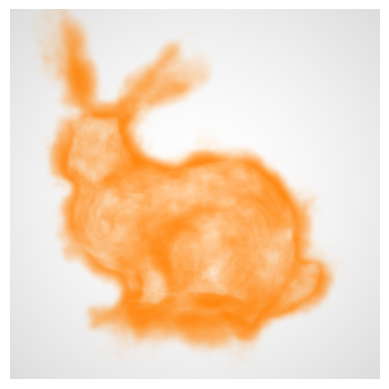

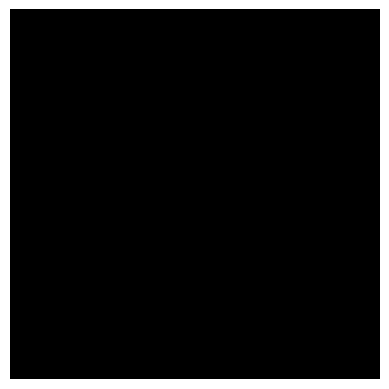

In [7]:
# Let's change the emission values in the volume to make the bunny glow
volume_data_rgba[..., 0:3] = [1.0, 0.5, 0.0]  # Set RGB channels to orange (emission)
volume = DenseVolume(
    name="volume",
    transform=Transform3D(
        position=glm.vec3(0.0, 0.0, 0.0),
        rotation=glm.angleAxis(glm.radians(90.0), glm.vec3(0.0, 1.0, 0.0)),
        scale=glm.vec3(1.0, 1.0, 1.0),
    ),
    data=volume_data_rgba.astype(np.float32),
    properties={
        "pivot": (0.5, 0.5, 0.5),
        "voxel_size": 0.02, # The size of each voxel in world units
    }
)
# Render the volume with absorption
renderer.load_triangles(scene=scene)
renderer.load_volume(volume=volume)
renderer.sqrt_spp = 1
renderer.render(
    scene.camera.view_matrix(),
    scene.camera.fov
)
plt.imshow(np.flipud(output_image.to_numpy()))
plt.axis('off')
plt.show()

### Wait, It's all Volume?

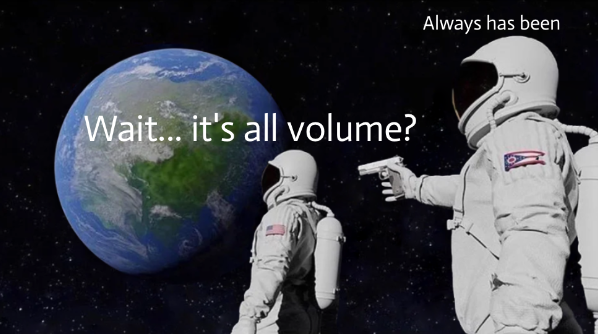

Once the volume has both emission and absorption, we can represent any scene using just volumes without any explicit surface! Download the `lego_volume.npy` file from the  assignment 2 resources folder: https://drive.google.com/drive/folders/1biYrBrNYx1sBlkcuyx3RARH9g9PaVHgL?usp=share_link and save it in the `resources` directory.

If you render this volume using your renderer, you should see the following result:

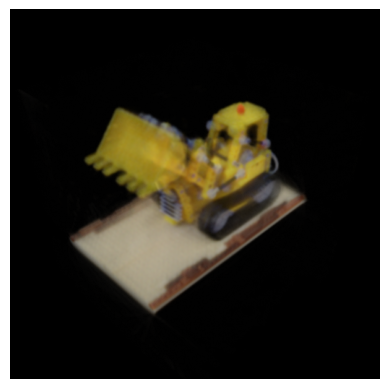

In the second part of this assignment, we'll learn how to recover such volume from multi-view images using differentiable rendering!

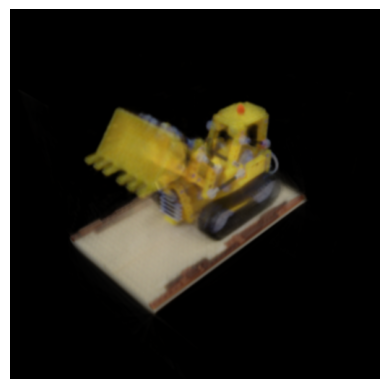

In [58]:
scene = Scene()
cam = scene.camera
cam_pos = glm.vec3(1, 1, 1) * 3
cam.transform.position = cam_pos
cam.transform.rotation = glm.quatLookAt(glm.normalize(-cam_pos), glm.vec3(0.0, 1.0, 0.0))

# Load the lego volume data
lego_volume = np.load("../../resources/lego_volume.npy")
volume = DenseVolume(
    name="volume",
    transform=Transform3D(
        position=glm.vec3(0.0, 0.0, 0.0),
        rotation=glm.angleAxis(glm.radians(-90.0), glm.vec3(1.0, 0.0, 0.0)),
        scale=glm.vec3(1.0, 1.0, 1.0),
    ),
    data=lego_volume.astype(np.float32),
    properties={
        "pivot": (0.5, 0.5, 0.5),
        "voxel_size": 0.02, # The size of each voxel in world units
    }
)
# Render the volume with absorption
renderer.load_triangles(scene=scene)
renderer.load_volume(volume=volume)
renderer.sqrt_spp = 1
renderer.render(
    scene.camera.view_matrix(),
    scene.camera.fov
)
plt.imshow(np.flipud(output_image.to_numpy()))
plt.axis('off')
plt.show()